In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from env import host, username, password
import utils

## Acquire and Summarize Data

- Acquired data requirements:
  - join all tables
  - only properties with transaction in 2017
  - ensure no duplicate property ids >> use latest transaction date
  - properties must contain latitude and longitude

In [2]:
#Function to create database url.  Requires local env.py with host, username and password. 
# No function help text provided as we don't want the user to access it and display their password on the screen
def get_db_url(db_name,user=username,password=password,host=host):
    url = f'mysql+pymysql://{user}:{password}@{host}/{db_name}'
    return url

#Function to get new data from Codeup server
def getNewZillowData():
    """
    Retrieves zillow dataset from Codeup DB and stores a local csv file
    Returns: Pandas dataframe
    """
    db_name= 'zillow'
    filename='zillow.csv'
    sql = """
    SELECT *
    FROM (SELECT max(transactiondate) AS transactiondate, parcelid FROM predictions_2017 GROUP BY parcelid) as T1
        JOIN predictions_2017 USING(transactiondate, parcelid)
        JOIN properties_2017 USING(parcelid)
        LEFT JOIN airconditioningtype USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        LEFT JOIN propertylandusetype USING (propertylandusetypeid)
        LEFT JOIN storytype USING (storytypeid)
        LEFT JOIN typeconstructiontype USING (typeconstructiontypeid)
    WHERE transactiondate LIKE '2017%%' 
        AND latitude IS NOT NULL
        AND longitude IS NOT NULL;
    """
    #Read SQL from file
    df = pd.read_sql(sql,get_db_url(db_name))
    #Drop ID columns
    df.drop(columns=['id'],inplace=True)
    #write to disk - writes index as col 0:
    df.to_csv(filename)
    return df

#Function to get data from local file or Codeup server 
def getZillowData():
    """
    Retrieves Zillow dataset from working directory or Codeup DB. Stores a local copy if one did not exist.
    Returns: Pandas dataframe of zillow data
    """
    #Set filename
    filename = 'zillow.csv'

    if os.path.isfile(filename): #check if file exists in WD
        #grab data, set first column as index
        return pd.read_csv(filename,index_col=[0])
    else: #Get data from SQL db
        df = getNewZillowData()
    return df

In [3]:
df = getZillowData()

/var/folders/dn/dr6y15951wq03xbh2xr9khq40000gn/T/ipykernel_85003/1610253724.py:1: DtypeWarning: Columns (63) have mixed types.Specify dtype option on import or set low_memory=False.
  df = getZillowData()


In [4]:
df.shape

(77380, 67)

In [5]:
df.parcelid.value_counts()

14297519    1
14409622    1
10830233    1
10914758    1
11656688    1
           ..
12060775    1
12453636    1
14707754    1
11697485    1
12826780    1
Name: parcelid, Length: 77380, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77380 entries, 0 to 77379
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        222 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77380 non-null  float64
 3   heatingorsystemtypeid         49439 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      206 non-null    float64
 6   airconditioningtypeid         24953 non-null  float64
 7   parcelid                      77380 non-null  int64  
 8   transactiondate               77380 non-null  object 
 9   logerror                      77380 non-null  float64
 10  basementsqft                  50 non-null     float64
 11  bathroomcnt                   77380 non-null  float64
 12  bedroomcnt                    77380 non-null  float64
 13  b

In [7]:
df.describe() 

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,logerror,basementsqft,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,222.000000,50.0,77380.000000,49439.000000,15.000000,206.000000,24953.000000,7.738000e+04,77380.000000,50.000000,...,77117.000000,17560.000000,172.0,7.726800e+04,7.737900e+04,77380.0,7.737800e+04,77375.000000,2886.000000,7.713600e+04
mean,6.040541,7.0,261.826350,3.920447,3.933333,7.388350,1.813289,1.300715e+07,0.016628,679.720000,...,1968.635943,1.434738,1.0,1.893160e+05,4.901375e+05,2016.0,3.010969e+05,5995.566592,14.087318,6.049674e+13
std,0.557285,0.0,5.141231,3.592789,0.258199,2.734542,2.967894,3.481368e+06,0.170190,689.703546,...,23.786166,0.544569,0.0,2.300886e+05,6.534477e+05,0.0,4.925990e+05,7622.887460,2.185663,1.535252e+12
min,4.000000,7.0,31.000000,1.000000,3.000000,2.000000,1.000000,1.071186e+07,-4.655420,38.000000,...,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13
25%,6.000000,7.0,261.000000,2.000000,4.000000,7.000000,1.000000,1.153830e+07,-0.024377,273.000000,...,1953.000000,1.000000,1.0,8.426500e+04,2.070000e+05,2016.0,8.550400e+04,2715.585000,14.000000,6.037311e+13
50%,6.000000,7.0,261.000000,2.000000,4.000000,7.000000,1.000000,1.253155e+07,0.006627,515.000000,...,1970.000000,1.000000,1.0,1.364995e+05,3.589760e+05,2016.0,2.033835e+05,4450.720000,15.000000,6.037603e+13
75%,6.000000,7.0,266.000000,7.000000,4.000000,7.000000,1.000000,1.421184e+07,0.039204,796.500000,...,1987.000000,2.000000,1.0,2.187875e+05,5.690030e+05,2016.0,3.668022e+05,6927.800000,15.000000,6.059042e+13
max,13.000000,7.0,275.000000,24.000000,4.000000,21.000000,13.000000,1.676893e+08,5.262999,3560.000000,...,2016.000000,6.000000,1.0,1.142179e+07,4.906124e+07,2016.0,4.895220e+07,586639.300000,99.000000,4.830301e+14


In [8]:
df.nunique().sort_values(ascending=False).head(30) #went back and dropped ID columns in getNewZillowData

parcelid                        77380
logerror                        76836
taxamount                       73824
latitude                        64037
longitude                       62460
landtaxvaluedollarcnt           51600
taxvaluedollarcnt               50948
structuretaxvaluedollarcnt      50429
rawcensustractandblock          39191
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
transactiondate                   264
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycoun

##### Look at number of nulls

In [9]:
col_nulls = utils.count_nulls(df)

<AxesSubplot:>

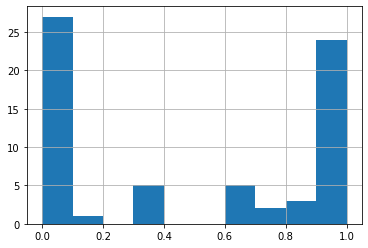

In [10]:
col_nulls.pct_nulls.hist()

**NOTES:** Looks like about 40% of the columns are < 20% populated, while another 40% are > 90% populated

In [11]:
#time intensive!
# row_nulls = utils.count_nulls(df,by_column=False)
# row_nulls.pct_nulls.hist()

**NOTES:** percent nulls per row are primarily between 40 and 60%. The lack of rows with full or no data seem to indicate that columns are the primary driver of missing data.

## Prepare

##### Remove properties that are unlikely to be single unit properties

Look at typeconstructiontypeid, lotsizesquarefeet, propertyzoningdesc, unitcnt, architecturalstyledesc, buildingclassdesc, propertylandusedesc

In [12]:
#unit count will likely take care of most of this
df.unitcnt.value_counts() #drop anything with more than 1 unit

1.0      47292
2.0       2018
4.0        723
3.0        525
45.0         1
42.0         1
6.0          1
237.0        1
Name: unitcnt, dtype: int64

In [13]:
df.unitcnt.isna().sum()

26818

**NOTES:** Unitcnt seems like a great choice for getting rid of parcels with >1 units.  However, I'll want to keep the null columns as that makes up a significant portion of the datapoints.

In [14]:
df.typeconstructiondesc.value_counts() #ignore

Frame       219
Masonry       1
Metal         1
Concrete      1
Name: typeconstructiondesc, dtype: int64

In [15]:
df.propertyzoningdesc.value_counts() #would need to compare with their meaning in CA.  Ignore for now

LAR1         6747
LAR3         2437
LARS         1389
LBR1N        1222
LARD1.5      1127
             ... 
PSR47200*       1
LBRR2I          1
PD SP           1
AVR2*           1
BFA15000*       1
Name: propertyzoningdesc, Length: 1907, dtype: int64

In [16]:
df.architecturalstyledesc.value_counts() #ignore, not enough information and no obvious issues

Contemporary     172
Conventional      19
Ranch/Rambler      7
Bungalow           5
Cape Cod           3
Name: architecturalstyledesc, dtype: int64

In [17]:
df.buildingclassdesc.value_counts() #very little info, mostly nulls anyway - Ignore

Buildings having wood or wood and steel frames                                                                                                                                                                                             14
Buildings having exterior walls built of a non-combustible material such as brick, concrete, block or poured concrete. Interior partitions and roof structures are built of combustible materials. Floor may be concrete or wood frame.     1
Name: buildingclassdesc, dtype: int64

In [18]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52319
Condominium                                   19294
Duplex (2 Units, Any Combination)              2009
Planned Unit Development                       1944
Quadruplex (4 Units, Any Combination)           727
Triplex (3 Units, Any Combination)              535
Cluster Home                                    333
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Residential General                              37
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [19]:
df.propertylandusetypeid.value_counts()

261.0    52319
266.0    19294
246.0     2009
269.0     1944
248.0      727
247.0      535
265.0      333
263.0       74
275.0       58
260.0       37
267.0       29
31.0        15
264.0        6
Name: propertylandusetypeid, dtype: int64

Per the [CA Builders website](https://cabuilderservices.com/planned-unit-development), PUDs can contain single family homes.  So it's possible new developments may not have the propertly land use type switched yet.

<AxesSubplot:>

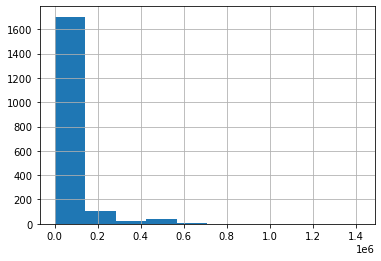

In [20]:
#see if they are huge lots (big lots likely mean it's the entire development region, not individual units)
df[df.propertylandusetypeid == 269].lotsizesquarefeet.hist()

In [21]:
#actually want to check against all possible values:
pd.read_sql('SELECT * FROM propertylandusetype',get_db_url('zillow'))

,propertylandusetypeid,propertylandusedesc
0,31,Commercial/Office/Residential Mixed Used
1,46,Multi-Story Store
2,47,Store/Office (Mixed Use)
3,246,"Duplex (2 Units, Any Combination)"
4,247,"Triplex (3 Units, Any Combination)"
5,248,"Quadruplex (4 Units, Any Combination)"
6,260,Residential General
7,261,Single Family Residential
8,262,Rural Residence
9,263,Mobile Home


In [22]:
#see if Duplexs are generally individual units or not
df[df.propertylandusetypeid == 246].unitcnt.value_counts()

2.0    1970
1.0      20
4.0       1
Name: unitcnt, dtype: int64

Helpful resource for determining appropriate building type/zoning. [Zillow types of houses](https://www.zillow.com/resources/stay-informed/types-of-houses/)

**Action:** Leave in:
- Single Family (261)
- PUD (269)
- Mobile home (263)
- Townhouse (264)
- Condominium (266)
- Manufactured, etc (275)
- Residential general (260)
- Rural residence (262)
- Bungalow (273)
- Zero Lot Line (274)
- Inferred Single Family (279)
- Patio Home (276)
 
List to include: [261,269,263,264,266,275,260,262,273,274,279,276]

**Note:** Leaving mobile homes as they could have individual parcels.  Leaving PUDs, as they seem appropriate to include (inappropriate ones may be removed with outliers based of lot size.)  Not including duplexes/triplex/etc, even though they can be sold as individual units, it would be hard to know if they were multiple or not (in particular, given that unitcnt is not always populated).  Excluding for this analysis.

##### Single unit filters:
- Only keep rows w/ unit counts of 1 or null
- Only include these property land use type ids: [261,269,263,264,266,275,260,262,273,274,279,276] 


In [23]:
df.shape

(77380, 67)

In [24]:
df[(df.unitcnt ==1) | df.unitcnt.isna()].shape

(74110, 67)

In [25]:
#only keep rows with unit count of 1 or null
df = df[(df.unitcnt ==1) | df.unitcnt.isna()]
#filter land use type
df = df[df.propertylandusetypeid.isin([261,269,263,264,266,275,260,262,273,274,279,276])]

In [26]:
df.shape

(73693, 67)

##### Create a function to drop rows or columns based on the percent of values missing

In [27]:
def handle_missing_values(old_df, prop_req_col=.75, prop_req_row=.75):
    """
    Checks the rows and columns for missing values.  Drops any rows or columns less than the specified percentage.
    
    Returnss: Dataframe
    Parameters: 
                df: Dataframe to analyze
      prop_req_col: Proportion (between 0 and 1) of values in column that must exist (non-null). Default: .75
      prop_req_row: Proportion (between 0 and 1) of values in a row that must exist (non-null). Default: .75
    """
    #make sure not to update external dataframe
    df=old_df.copy()
    #Determine number of required non-nulls in columns (prop * num_rows)
    col_thresh = int(round(prop_req_col*df.shape[0],0))
    #drop columns w/o enough info
    df.dropna(axis=1,thresh=col_thresh,inplace=True)
    
    #NOW DO ROWS - note, this on already trimmed df
    #Determine number of required non-nulls in rows (prop * num_cols)
    row_thresh = int(round(prop_req_row*df.shape[1],0))
    #drop rows w/o enough info
    df.dropna(axis=0,thresh=row_thresh,inplace=True)
    
    return df

<AxesSubplot:>

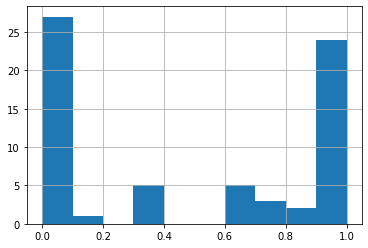

In [28]:
#Look at nulls again
col_nulls = utils.count_nulls(df)
col_nulls.pct_nulls.hist()

Looking at this, I'm think I can either use all the very full columns, or try dropping columns with less than 90% of data and seeing if dropping rows with zeros accounts to minimal loss of observation and maximum columns

Try: 
- no nulls in columns
- <10% nulls in columns
- <5% nulls in columns

then go from there


In [29]:
print(f'{(col_nulls.pct_nulls < .1).sum()} columns if I keep them with <10% nulls')
print(f'{(col_nulls.pct_nulls < .05).sum()} columns if I keep them with <5% nulls')
print(f'{(col_nulls.pct_nulls < .02).sum()} columns if I keep them with <2% nulls')
print(f'{(col_nulls.pct_nulls == 0).sum()} columns if I keep them with 0 nulls')

27 columns if I keep them with <10% nulls
27 columns if I keep them with <5% nulls
27 columns if I keep them with <2% nulls
15 columns if I keep them with 0 nulls


In [30]:
#now let's see how many rows we lose if we drop the other nulls
handle_missing_values(df,prop_req_col=.98,prop_req_row=1).shape

(71517, 27)

**NOTES:** For this subset, we can get the bulk of our columns by making a cutoff of .98, and we only lose 4k of our rows. THIS MAY NOT APPLY TO FUTURE DATASETS

**ACTION:** handle missing values by dropping any columns with <98% of values, then dropping any rows with nulls.

In [31]:
df = handle_missing_values(df,prop_req_col=.98,prop_req_row=1)
df.shape

(71517, 27)

##### Imputing notes
- Not imputing for this evolution
- **Time Permitting:**
  - check out KNNImputer
    - Looks like fiting imputer can use subset of columns
    - Will take the mode, which means it won't work well for continuous columns. But, it may still be appropriate.  Finding the absolute closest neighbor and just using it's value.
  - when would KNN be more appropriate?


##### Look at duplicate columns and data types

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71517 entries, 0 to 77379
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         71517 non-null  float64
 1   parcelid                      71517 non-null  int64  
 2   transactiondate               71517 non-null  object 
 3   logerror                      71517 non-null  float64
 4   bathroomcnt                   71517 non-null  float64
 5   bedroomcnt                    71517 non-null  float64
 6   calculatedbathnbr             71517 non-null  float64
 7   calculatedfinishedsquarefeet  71517 non-null  float64
 8   finishedsquarefeet12          71517 non-null  float64
 9   fips                          71517 non-null  float64
 10  fullbathcnt                   71517 non-null  float64
 11  latitude                      71517 non-null  float64
 12  longitude                     71517 non-null  float64
 13  p

**ACTION:** drop propertylandusetypeid, duplicate

In [33]:
#calculatedbathnbr is number of bathrooms (non-fractional)
(df.bathroomcnt == df.calculatedbathnbr).mean() #the same,drop calc bath

1.0

In [34]:
(df.fullbathcnt <= df.bathroomcnt).mean()#good

1.0

In [35]:
(df.fullbathcnt% 1).value_counts() #convert to int

0.0    71517
Name: fullbathcnt, dtype: int64

In [36]:
(df.fullbathcnt == df.bathroomcnt).mean() #good

0.8631094704755513

In [37]:
(df.bedroomcnt % 1).value_counts() #convert to int

0.0    71517
Name: bedroomcnt, dtype: int64

<AxesSubplot:>

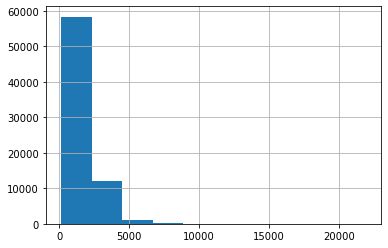

In [38]:
df.calculatedfinishedsquarefeet.hist() 

In [39]:
(df.calculatedfinishedsquarefeet %1).value_counts() #convert to int

0.0    71517
Name: calculatedfinishedsquarefeet, dtype: int64

<AxesSubplot:>

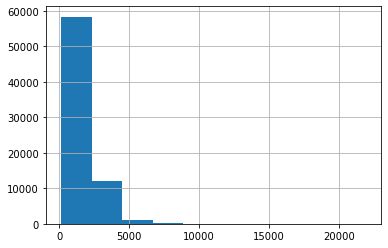

In [40]:
#finished living area
df.finishedsquarefeet12.hist()

In [41]:
(df.finishedsquarefeet12 == df.calculatedfinishedsquarefeet).mean()

1.0

since those are the same, drop finishedsquarefeet12

In [42]:
df.fips.value_counts() #map to county names, then drop

6037.0    46191
6059.0    19619
6111.0     5707
Name: fips, dtype: int64

In [43]:
print(f'min lat: {df.latitude.min()}')
print(f'max lat: {df.latitude.max()}')
print(f'min lon: {df.longitude.min()}')
print(f'max lon: {df.longitude.max()}')

min lat: 33339527.0
max lat: 34818767.0
min lon: -119475265.0
max lon: -117572338.0


In [44]:
(df.latitude % 1).value_counts() 

0.0    71517
Name: latitude, dtype: int64

In [45]:
(df.longitude % 1).value_counts() 

0.0    71517
Name: longitude, dtype: int64

lat/long should be middle of parcel * 10e6.  Good to convert to int

In [46]:
df.propertycountylandusecode.value_counts()

0100    26100
122     12539
010C     8636
0101     6178
34       4828
1111     3337
1        2252
010E     2005
010D     1822
1129     1374
1110      979
0104      359
012C      307
01DC      200
01HC      134
010G       93
0103       89
010H       64
0108       55
0700       50
010M       50
010V        8
0109        7
1116        7
1117        6
0110        6
0113        6
012E        5
1120        3
0102        3
070D        2
0111        2
0105        2
0130        2
0141        2
0133        1
0131        1
1112        1
012D        1
0114        1
Name: propertycountylandusecode, dtype: int64

In [47]:
(df.rawcensustractandblock % 1).value_counts() 

0.022000    389
0.021000    381
0.011000    359
0.002001    354
0.002000    343
           ... 
0.423015      1
0.212027      1
0.016020      1
0.021072      1
0.262006      1
Name: rawcensustractandblock, Length: 5579, dtype: int64

In [48]:
df.rawcensustractandblock.value_counts() 

6.059063e+07    60
6.037137e+07    60
6.037277e+07    51
6.059032e+07    43
6.037139e+07    40
                ..
6.037433e+07     1
6.037135e+07     1
6.037108e+07     1
6.037103e+07     1
6.037503e+07     1
Name: rawcensustractandblock, Length: 36169, dtype: int64

In [49]:
df.censustractandblock.value_counts() 

6.037137e+13    60
6.037277e+13    51
6.059032e+13    44
6.059063e+13    41
6.037139e+13    40
                ..
6.037103e+13     1
6.037197e+13     1
6.037193e+13     1
6.037901e+13     1
6.037503e+13     1
Name: censustractandblock, Length: 36042, dtype: int64

In [50]:
(df.regionidzip % 1).value_counts() #convert to int

0.0    71517
Name: regionidzip, dtype: int64

In [51]:
df.regionidcity.value_counts()

12447.0     16350
46298.0      2350
54311.0      1871
5534.0       1864
52650.0      1628
            ...  
118880.0        5
10815.0         4
13311.0         4
36078.0         1
21395.0         1
Name: regionidcity, Length: 175, dtype: int64

In [52]:
df.regionidcounty.value_counts() #duplicate of fips, drop

3101.0    46191
1286.0    19619
2061.0     5707
Name: regionidcounty, dtype: int64

In [53]:
df.roomcnt.value_counts() #to int

0.0     54756
6.0      4332
7.0      3736
8.0      2825
5.0      2812
4.0      1213
9.0      1174
10.0      336
3.0       173
11.0      103
12.0       33
13.0        9
2.0         8
14.0        5
1.0         1
15.0        1
Name: roomcnt, dtype: int64

In [54]:
(df.yearbuilt % 1).value_counts() 

0.0    71517
Name: yearbuilt, dtype: int64

In [55]:
df.assessmentyear.value_counts() #drop

2016.0    71517
Name: assessmentyear, dtype: int64

In [56]:
df.transactiondate.value_counts() #pull out month, rename

2017-06-30    1081
2017-04-28     835
2017-05-31     799
2017-07-28     749
2017-08-31     716
              ... 
2017-07-08       1
2017-04-08       1
2017-04-15       1
2017-06-03       1
2017-09-25       1
Name: transactiondate, Length: 263, dtype: int64

In [57]:
pd.DatetimeIndex(df['transactiondate']).month

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
           dtype='int64', name='transactiondate', length=71517)

In [58]:
df.columns

Index(['propertylandusetypeid', 'parcelid', 'transactiondate', 'logerror',
       'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'propertylandusedesc'],
      dtype='object')

### Preparation Notes
- Filtered out single units by:
    - Filter out unitcnts > 1 (not dropping nulls)
    - Only keep parcels with a propertylandusetypeid of:
      -  Single Family (261)
      - PUD (269)
      - Mobile home (263)
      - Townhouse (264)
      - Condominium (266)
      - Manufactured, etc (275)
      - Residential general (260)
      - Rural residence (262)
      - Bungalow (273)
      - Zero Lot Line (274)
      - Inferred Single Family (279)
      - Patio Home (276)
- There were quite a few nulls in some columns, after investigating, chose to drop any columns with >=2% nulls, then drop all rows.

**GEOGRAPHIC ATTRIBUTES:** Since many of these involve a large amount of categories, I will drop any geographic attributes that aren't lat/lon and county.  We can always us lat/lon for knn and we can use it to pull geographic attributes using apis in the future.

- Drop columns:
    - Propertylandusetypeid: duplicate
    - finishedsquarefeet12: duplicate
    - calculatedbathnbr: duplicate
    - regionidcounty: duplicate
    - structuretaxvaluedollarcnt, landtaxvaluedollarcnt, tax amount: not independent of tax value
    - Assessmentyear: all the same value
    - : related to censustractandblock, but with less characters, use other.
    - geographic: regionidcity, regionidzip, rawcensustractandblock, censustractandblock, 
- Convert to INT
    - Bedroomcnt
    - Year built
    - Fullbathcnt
    - Lat and long
    - Roomcnt
    - calculatedfinishedsquarefeet
- convert transaction date to month, then drop
- fips:
    - Map to county names
- encode:
    - County


##### Look at outliers

In [59]:
bounds = utils.get_iqr_outlier_bounds(df)

In [60]:
bounds

,propertylandusetypeid,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
lb,253.5,7474738.0,-0.116278,0.5,-1.0,0.5,-169.5,-169.5,6004.0,0.5,...,-1436.5,95034.5,0.0,1904.5,-114539.0,-334431.5,2016.0,-339840.0,-3501.10,6.004737e+13
ub,273.5,18278018.0,0.130773,4.5,7.0,4.5,3402.5,3402.5,6092.0,4.5,...,5823.5,98158.5,0.0,2036.5,415077.0,1105724.5,2016.0,789992.0,13020.82,6.091626e+13


In [61]:
#trim outliers using IQR, only do outliers on these columns:
#. ['bedroomcnt','calculatedbathnbr','calculatedfinishedsquarefeet', 'taxvaluedollarcnt','logerror']
df.shape

(71517, 27)

##### Put preparation actions into functions and test

In [62]:
def only_single_unit(df):
    '''
    This function takes in a zillow dataframe and drops any rows with unitcnt > 2(keeps nulls).
    It also keeps parcels of the following property land use type:  
        Single Family (261), PUD (269), Mobile home (263), Townhouse (264), Condominium (266),
        Manufactured, etc (275), Residential general (260), Rural residence (262), Bungalow (273),
        Zero Lot Line (274), Inferred Single Family (279), Patio Home (276)
    '''
    #only keep rows with unit count of 1 or null
    df = df[(df.unitcnt ==1) | df.unitcnt.isna()]
    #filter land use type
    df = df[df.propertylandusetypeid.isin([261,269,263,264,266,275,260,262,273,274,279,276])]
    return df

def map_encode_zillow_fips(df):
    #map to county names
    df['county'] = df.fips.map({6037: 'LosAngeles',6059:'Orange',6111:'Ventura'})
    #encode into dummy df
    d_df = pd.get_dummies(df['county'],drop_first=True)
    #concat dummy df to the rest
    df = pd.concat([df,d_df],axis=1)
    #Drop fips
    df.drop(columns=['fips'],inplace=True)
    return df

def prep_zillow(df):
    '''
    This function takes in a zillow dataframe and prepares it for exploratory analysis.
    '''
    #FILTER down to 'single unit' properties
    df = only_single_unit(df)
    
    #NULLS: filter down null-heavy columns, then drop rows with nulls
    df = handle_missing_values(df,prop_req_col=.98,prop_req_row=1)
    
    #DROP remaining columns I don't want - do geographic columns separately to easily change
    drp_cols = ['propertylandusetypeid', 'finishedsquarefeet12', 'structuretaxvaluedollarcnt','calculatedbathnbr',\
                'assessmentyear','landtaxvaluedollarcnt', 'taxamount']
    drp_geo_cols = ['regionidcity','regionidcounty', 'regionidzip','rawcensustractandblock','censustractandblock']
    df.drop(columns=(drp_cols+drp_geo_cols), inplace=True)
#     df.drop(columns=drp_geo_cols, inplace=True)

    #CONVERT datatypes
    to_int_cols = ['bedroomcnt', 'yearbuilt', 'fullbathcnt', 'latitude', 'longitude','roomcnt','calculatedfinishedsquarefeet']
    df[to_int_cols] = df[to_int_cols].astype(int)
    
    #CONVERT transactiondate
    df['trans_month'] = pd.DatetimeIndex(df['transactiondate']).month
    df.drop(columns='transactiondate',inplace=True)
    
    #MOVE parcelid to index
    df.set_index('parcelid',drop=True,inplace=True)
    
    #MAP and ENCODE fips
    df = map_encode_zillow_fips(df)
    
    #TRIM IQR outliers
    iqr_trim_cols = ['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet', 'taxvaluedollarcnt','logerror']
    df = utils.handle_iqr_outliers(df,trim=True,include=iqr_trim_cols)
    
    #RENAME columns
    rename_cols = {
        'bedroomcnt':'bed',
        'bathroomcnt':'bath',
        'calculatedfinishedsquarefeet':'sf',
        'latitude': 'lat',
        'longitude':'lon',
        'propertycountylandusecode':'countylanduse',
        'propertylandusedesc':'landusedesc',
        'taxvaluedollarcnt':'value'
    }
    df.rename(columns=rename_cols,inplace=True)
    
    return df    

In [63]:
#let's see if all that worked!
new_df = getZillowData()
new_df = prep_zillow(new_df)

/var/folders/dn/dr6y15951wq03xbh2xr9khq40000gn/T/ipykernel_85003/3165471118.py:2: DtypeWarning: Columns (63) have mixed types.Specify dtype option on import or set low_memory=False.
  new_df = getZillowData()


In [64]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57895 entries, 14297519 to 12826780
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   logerror       57895 non-null  float64
 1   bath           57895 non-null  float64
 2   bed            57895 non-null  int64  
 3   sf             57895 non-null  int64  
 4   fullbathcnt    57895 non-null  int64  
 5   lat            57895 non-null  int64  
 6   lon            57895 non-null  int64  
 7   countylanduse  57895 non-null  object 
 8   roomcnt        57895 non-null  int64  
 9   yearbuilt      57895 non-null  int64  
 10  value          57895 non-null  float64
 11  landusedesc    57895 non-null  object 
 12  trans_month    57895 non-null  int64  
 13  county         57895 non-null  object 
 14  Orange         57895 non-null  uint8  
 15  Ventura        57895 non-null  uint8  
dtypes: float64(3), int64(8), object(3), uint8(2)
memory usage: 6.7+ MB


- Right number of rows >> IQR dropped ~13k rows
- appropriate columns remaining
- appropriate datatypes
